In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from mini_torch import Tensor, nn, optim, F

## Load and Preprocess MNIST Dataset

In [2]:
# Load MNIST dataset
print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data.to_numpy(), mnist.target.to_numpy().astype(int)

# Use subset for faster training on CPU (10,000 samples)
X = X[:10000]
y = y[:10000]

# Normalize pixel values
X = X / 255.0

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Input dimension: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

Loading MNIST dataset...
Training set size: 8000
Test set size: 2000
Input dimension: 784
Number of classes: 10


## Visualize Sample Images

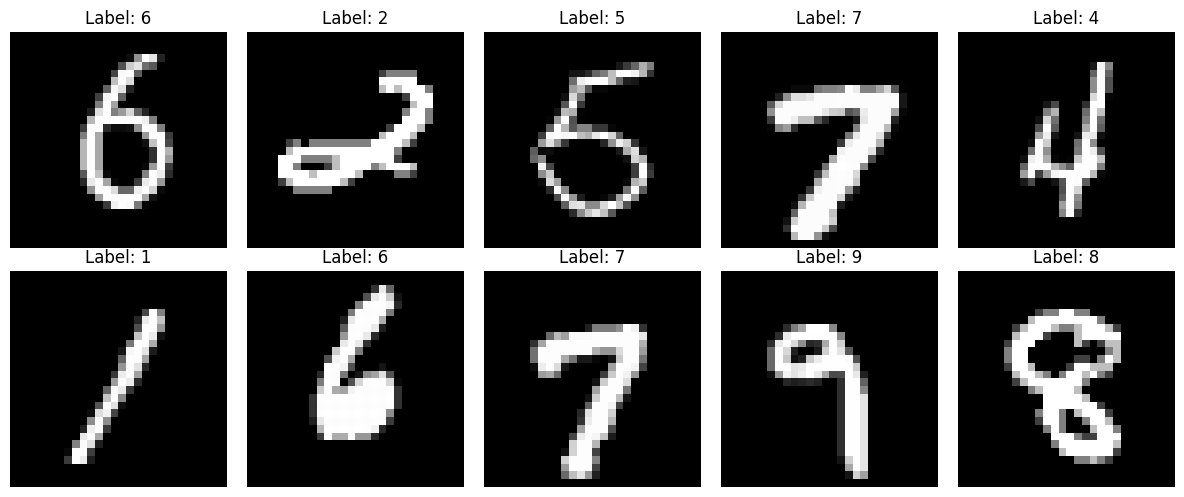

In [3]:
# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Define MLP Model

In [4]:
class MLP(nn.Module):
    """Multi-Layer Perceptron with 2 hidden layers"""
    
    def __init__(self, input_size=784, hidden1=128, hidden2=64, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)
        
        # Collect parameters
        self._parameters = self.fc1.parameters() + self.fc2.parameters() + self.fc3.parameters()
    
    def forward(self, x):
        # Input shape: (batch_size, 784)
        x = self.fc1(x)
        x = x.relu()  # ReLU activation
        
        x = self.fc2(x)
        x = x.relu()  # ReLU activation
        
        x = self.fc3(x)
        # Output shape: (batch_size, 10) - logits
        return x

# Create model
model = MLP(input_size=784, hidden1=128, hidden2=64, num_classes=10)
print(f"Model created with {len(model.parameters())} parameter tensors")

Model created with 6 parameter tensors


## Training Function

In [5]:
def train_epoch(model, X_train, y_train, optimizer, batch_size=32):
    """Train for one epoch"""
    n_samples = X_train.shape[0]
    indices = np.random.permutation(n_samples)
    
    epoch_loss = 0.0
    n_batches = 0
    
    for i in range(0, n_samples, batch_size):
        # Get batch
        batch_indices = indices[i:i+batch_size]
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        
        # Convert to Tensors
        X_tensor = Tensor(X_batch.astype(np.float32))
        y_tensor = Tensor(y_batch.astype(np.float32), requires_grad=False)
        
        # Forward pass
        logits = model(X_tensor)
        
        # Compute loss
        loss = F.cross_entropy(logits, y_tensor)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    return epoch_loss / n_batches


def evaluate(model, X_test, y_test, batch_size=32):
    """Evaluate model accuracy"""
    n_samples = X_test.shape[0]
    correct = 0
    total = 0
    
    for i in range(0, n_samples, batch_size):
        X_batch = X_test[i:i+batch_size]
        y_batch = y_test[i:i+batch_size]
        
        # Convert to Tensor
        X_tensor = Tensor(X_batch.astype(np.float32))
        
        # Forward pass
        logits = model(X_tensor)
        
        # Get predictions
        predictions = np.argmax(logits.data, axis=1)
        
        correct += (predictions == y_batch).sum()
        total += len(y_batch)
    
    return correct / total

## Train with Different Optimizers

In [6]:
# Training configuration
n_epochs = 10
batch_size = 64

# Define optimizers to compare
optimizers_to_test = [
    ('SGD', lambda params: optim.SGD(params, learning_rate=0.1)),
    ('Momentum', lambda params: optim.Momentum(params, learning_rate=0.1, momentum=0.9)),
    ('Adagrad', lambda params: optim.Adagrad(params, learning_rate=0.01)),
    ('RMSProp', lambda params: optim.RMSProp(params, learning_rate=0.001, decay=0.9)),
    ('Adam', lambda params: optim.Adam(params, learning_rate=0.001)),
    ('AdamW', lambda params: optim.AdamW(params, learning_rate=0.001, weight_decay=0.01)),
    ('Adadelta', lambda params: optim.Adadelta(params, rho=0.95)),
]

# Store results
results = {}

for opt_name, opt_fn in optimizers_to_test:
    print(f"\n{'='*60}")
    print(f"Training with {opt_name} optimizer")
    print('='*60)
    
    # Create fresh model
    model = MLP(input_size=784, hidden1=128, hidden2=64, num_classes=10)
    optimizer = opt_fn(model.parameters())
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(n_epochs):
        # Train
        train_loss = train_epoch(model, X_train, y_train, optimizer, batch_size)
        train_losses.append(train_loss)
        
        # Evaluate
        test_acc = evaluate(model, X_test, y_test, batch_size)
        test_accuracies.append(test_acc)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {train_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    results[opt_name] = {
        'train_losses': train_losses,
        'test_accuracies': test_accuracies
    }

print("\n" + "="*60)
print("Training completed!")
print("="*60)


Training with SGD optimizer
Epoch 1/10 - Loss: 0.8739, Test Acc: 0.8465
Epoch 2/10 - Loss: 0.3545, Test Acc: 0.9130
Epoch 3/10 - Loss: 0.2743, Test Acc: 0.9275
Epoch 4/10 - Loss: 0.2256, Test Acc: 0.9405
Epoch 5/10 - Loss: 0.1933, Test Acc: 0.9340
Epoch 6/10 - Loss: 0.1672, Test Acc: 0.9420
Epoch 7/10 - Loss: 0.1491, Test Acc: 0.9500
Epoch 8/10 - Loss: 0.1317, Test Acc: 0.9490
Epoch 9/10 - Loss: 0.1132, Test Acc: 0.9550
Epoch 10/10 - Loss: 0.1030, Test Acc: 0.9445

Training with Momentum optimizer
Epoch 1/10 - Loss: 0.5851, Test Acc: 0.9240
Epoch 2/10 - Loss: 0.2429, Test Acc: 0.9395
Epoch 3/10 - Loss: 0.1684, Test Acc: 0.9420
Epoch 4/10 - Loss: 0.1115, Test Acc: 0.9480
Epoch 5/10 - Loss: 0.0796, Test Acc: 0.9460
Epoch 6/10 - Loss: 0.0846, Test Acc: 0.9070
Epoch 7/10 - Loss: 0.0783, Test Acc: 0.9560
Epoch 8/10 - Loss: 0.0602, Test Acc: 0.9485
Epoch 9/10 - Loss: 0.0516, Test Acc: 0.9550
Epoch 10/10 - Loss: 0.0246, Test Acc: 0.9470

Training with Adagrad optimizer
Epoch 1/10 - Loss: 0.5

## Visualize Results

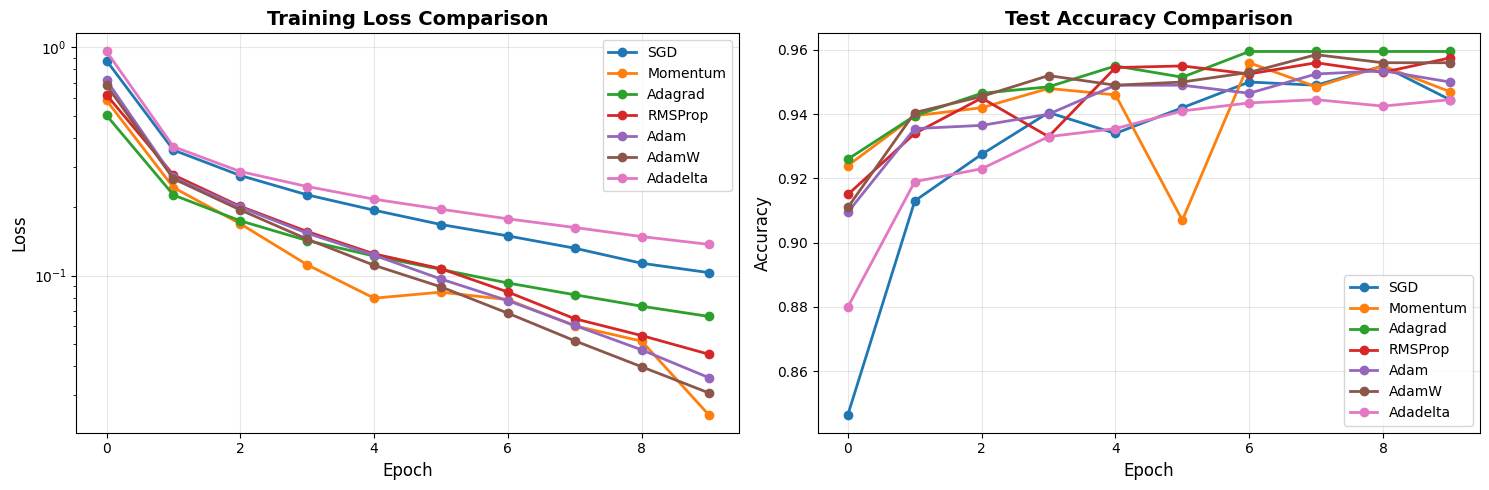

In [7]:
# Plot training loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training loss comparison
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
for opt_name, data in results.items():
    ax1.plot(data['train_losses'], marker='o', label=opt_name, linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Test accuracy comparison
ax2.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
for opt_name, data in results.items():
    ax2.plot(data['test_accuracies'], marker='o', label=opt_name, linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Final Performance Summary

In [8]:
# Create summary table
print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)
print(f"{'Optimizer':<15} {'Final Loss':<15} {'Final Accuracy':<15} {'Best Accuracy':<15}")
print("-"*70)

for opt_name, data in results.items():
    final_loss = data['train_losses'][-1]
    final_acc = data['test_accuracies'][-1]
    best_acc = max(data['test_accuracies'])
    print(f"{opt_name:<15} {final_loss:<15.4f} {final_acc:<15.4f} {best_acc:<15.4f}")

print("="*70)


FINAL PERFORMANCE SUMMARY
Optimizer       Final Loss      Final Accuracy  Best Accuracy  
----------------------------------------------------------------------
SGD             0.1030          0.9445          0.9550         
Momentum        0.0246          0.9470          0.9560         
Adagrad         0.0662          0.9595          0.9595         
RMSProp         0.0452          0.9575          0.9575         
Adam            0.0357          0.9500          0.9535         
AdamW           0.0306          0.9560          0.9585         
Adadelta        0.1369          0.9445          0.9445         


## Test Predictions Visualization

Training final model with Adam...
Epoch 3/10 - Loss: 0.2017
Epoch 6/10 - Loss: 0.0912
Epoch 9/10 - Loss: 0.0441


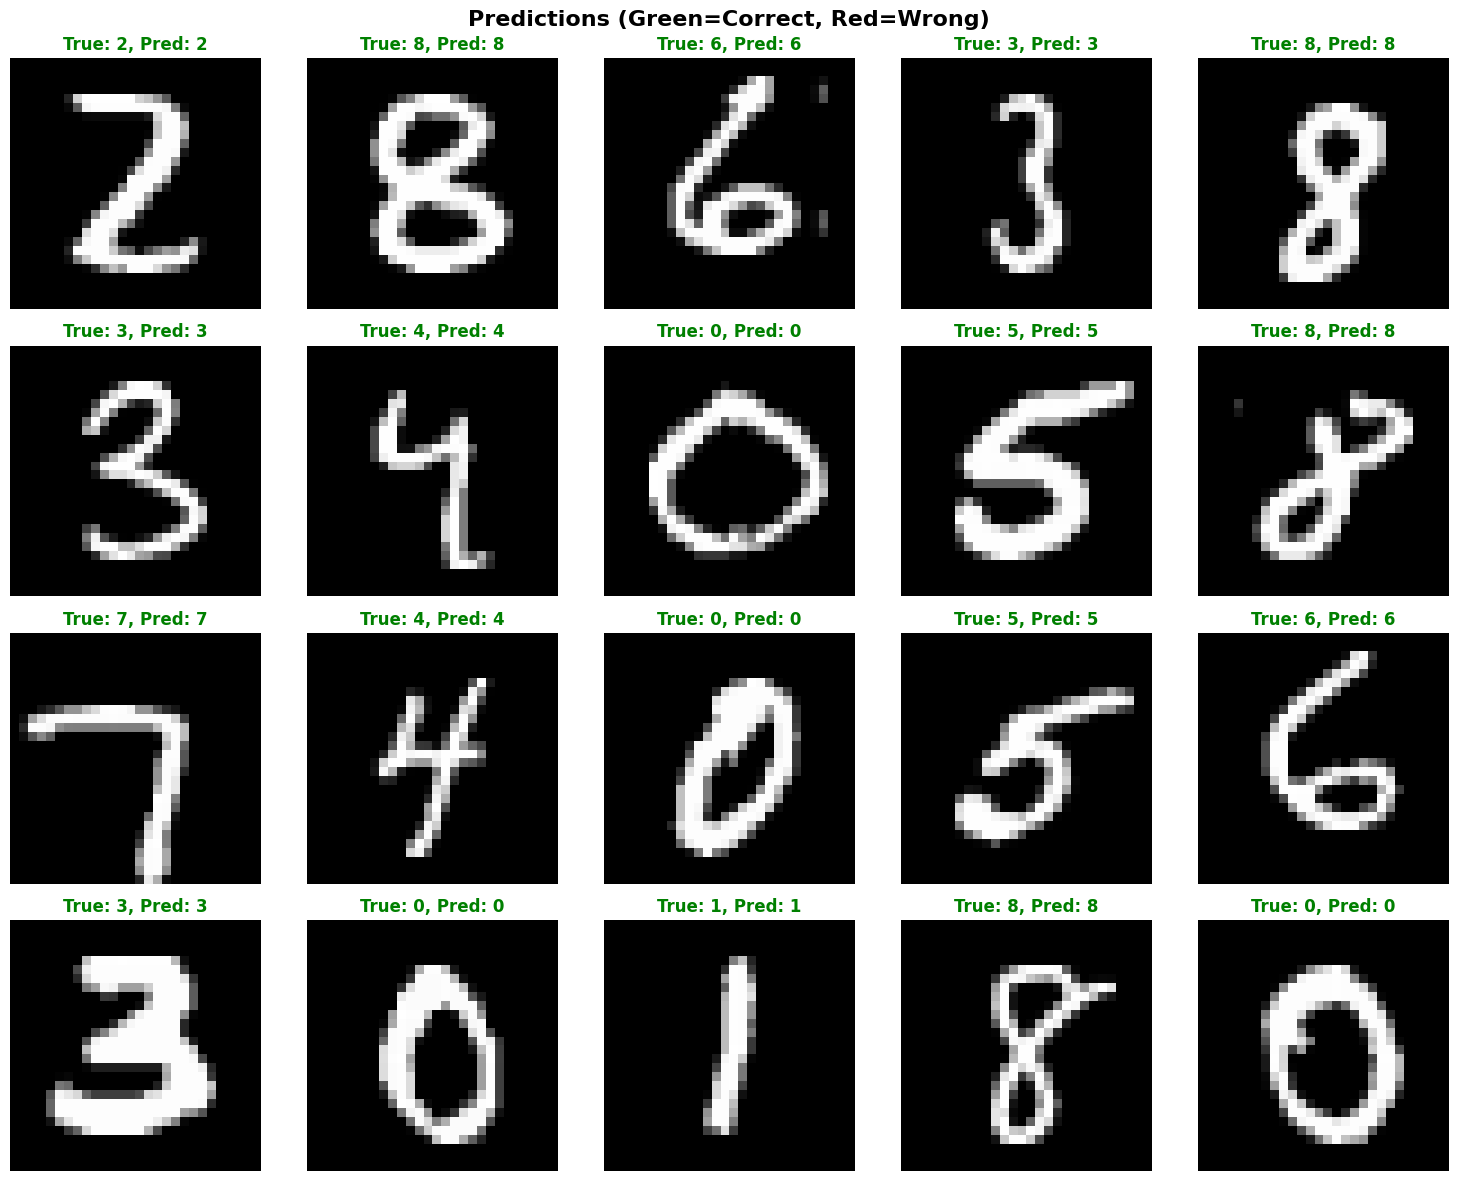


Accuracy on visualized samples: 100.00%


In [9]:
# Use the best performing model (Adam) for prediction visualization
model = MLP(input_size=784, hidden1=128, hidden2=64, num_classes=10)
optimizer = optim.Adam(model.parameters(), learning_rate=0.001)

# Quick training
print("Training final model with Adam...")
for epoch in range(10):
    train_loss = train_epoch(model, X_train, y_train, optimizer, batch_size)
    if (epoch + 1) % 3 == 0:
        print(f"Epoch {epoch+1}/10 - Loss: {train_loss:.4f}")

# Visualize predictions
n_samples_viz = 20
X_viz = X_test[:n_samples_viz]
y_viz = y_test[:n_samples_viz]

X_tensor = Tensor(X_viz.astype(np.float32))
logits = model(X_tensor)
predictions = np.argmax(logits.data, axis=1)

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_viz[i].reshape(28, 28), cmap='gray')
    color = 'green' if predictions[i] == y_viz[i] else 'red'
    ax.set_title(f'True: {y_viz[i]}, Pred: {predictions[i]}', color=color, fontweight='bold')
    ax.axis('off')

plt.suptitle('Predictions (Green=Correct, Red=Wrong)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate accuracy
accuracy = (predictions == y_viz).sum() / len(y_viz)
print(f"\nAccuracy on visualized samples: {accuracy:.2%}")